In [2]:
# tedscott
# 11.8.2016
# try using the derviatives of the command usage week-over-week data
# from the Device Table to predict retention

import matplotlib
import pandas as pd
import os.path
import numpy as np
import time
import subprocess

from scipy import stats

from sklearn.linear_model import LogisticRegression
from sklearn import cross_validation
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline


In [3]:
pathName="E:/python-stuff/data/"
# 500000 sample
fileName = "DerivativeRetention500000.csv"

# full data set (39M devices, 5 GB csv)
#fileName = "DerivativeRetentionFull.csv"
filePath = os.path.join(pathName, fileName)

# load the DF
derivDF = pd.read_csv(filePath)

In [4]:
derivDF.head()

,SqmUserId,SnapshotTime,dDistCmdsWk0Wk1,dDistCmdsWk1Wk2,dDistCmdsWk2Wk3,dTotCmdsWk0Wk1,dTotCmdsWk1Wk2,dTotCmdsWk2Wk3,AvgdDistCmds,AvgdTotCmds,RetainedExcel
0,000608fd-a577-4097-915b-a53c7bffa913,8/28/2016 12:00:00 AM,1.75,-28.50,34.00,36.00,-251.50,283.00,2.42,22.50,0
1,00271c75-00ad-4808-a32c-cfca6fc5f5a6,8/28/2016 12:00:00 AM,1.80,-1.30,0.50,-0.40,0.90,-2.50,0.33,-0.67,1
2,003c6076-5567-481f-815f-0c18cecff1e7,8/28/2016 12:00:00 AM,-2.65,3.80,-8.07,-31.65,-102.60,70.00,-2.31,-21.42,1
3,0058efa2-2252-46c5-a0be-58886623b4dd,8/28/2016 12:00:00 AM,12.33,-0.33,-9.67,109.00,-2.67,-74.83,0.78,10.50,1
4,00145c88-acb1-4cc2-8d23-e512a3410f2a,8/28/2016 12:00:00 AM,9.50,0.00,0.00,22.00,0.00,0.00,3.17,7.33,0


In [5]:
derivDF.describe()

,dDistCmdsWk0Wk1,dDistCmdsWk1Wk2,dDistCmdsWk2Wk3,dTotCmdsWk0Wk1,dTotCmdsWk1Wk2,dTotCmdsWk2Wk3,AvgdDistCmds,AvgdTotCmds,RetainedExcel
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,0.359940,0.108452,0.012564,2.601668,0.222253,-0.273755,0.160284,0.850032,0.696876
std,6.604646,6.329832,6.188103,73.932363,71.931518,64.085317,2.305068,24.501930,0.459609
min,-161.000000,-213.000000,-154.000000,-15562.670000,-7638.270000,-2102.000000,-51.330000,-1463.610000,0.000000
25%,-1.170000,-1.000000,-1.170000,-4.000000,-4.000000,-4.000000,-0.500000,-1.670000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2.000000,1.330000,1.000000,7.000000,4.000000,3.330000,0.730000,2.750000,1.000000
max,134.500000,161.000000,216.000000,10113.670000,15562.670000,6358.000000,44.670000,2216.830000,1.000000


In [6]:
derivDF.SqmUserId.unique().size

500000

In [7]:
# remove outliers?
# try removing all those that have values more than 3 SD away from mean
derivDFClean = derivDF.drop(["SqmUserId","SnapshotTime"], axis=1)
derivDFClean = derivDFClean[(np.abs(stats.zscore(derivDFClean)) < 3).all(axis=1)]



In [8]:
derivDFClean.head()
print(derivDFClean.count())

dDistCmdsWk0Wk1    462201
dDistCmdsWk1Wk2    462201
dDistCmdsWk2Wk3    462201
dTotCmdsWk0Wk1     462201
dTotCmdsWk1Wk2     462201
dTotCmdsWk2Wk3     462201
AvgdDistCmds       462201
AvgdTotCmds        462201
RetainedExcel      462201
dtype: int64


In [9]:
# try just avgs for predictors?
# used derivDF.columns.tolist() to get feature lists
predictors=["AvgdDistCmds","AvgdTotCmds"]
predictorsAll=['dDistCmdsWk0Wk1', 'dDistCmdsWk1Wk2', 'dDistCmdsWk2Wk3', 'dTotCmdsWk0Wk1',
               'dTotCmdsWk1Wk2', 'dTotCmdsWk2Wk3', 'AvgdDistCmds', 'AvgdTotCmds']

In [10]:
# try random forest to predict retention of Excel users
# 13 sec on sampled 500000 data

X = derivDFClean[predictorsAll]
y = derivDFClean["RetainedExcel"]

clf = RandomForestClassifier(n_estimators=10, max_features=2, min_samples_split=5, n_jobs=2)
start = time.time()
clf.fit(X, y)
print("training time: % sec", time.time() - start)

# show table of results
print(pd.crosstab(derivDFClean.RetainedExcel, clf.predict(derivDFClean[predictorsAll]), rownames=["Actual"], colnames=["Pred"]))

# accuracy on training set
# scoring
score = clf.score(X, y)
print("Accuracy training on full dataset: %", score)

# AUC
print("AUC: %", roc_auc_score(derivDFClean.RetainedExcel, clf.predict(derivDFClean[predictorsAll])))

# retention
print("Average M2 Retention for Excel sample: %", derivDF.RetainedExcel.mean()*100)

training time: % sec 5.085453033447266
Pred         0       1
Actual                
0       100564   40031
1        46627  274979
Accuracy training on full dataset: % 0.812510141692
AUC: % 0.785146310895
Average M2 Retention for Excel sample: % 69.6876


In [11]:
# feature importances show that the Wk0-Wk1 Total Commands and the Avg dTot Commands (average of all three slopes)
# are the best features
clf.feature_importances_

array([ 0.12406103,  0.09369394,  0.09691724,  0.15686286,  0.13695351,
        0.11676305,  0.11737296,  0.15737542])

In [12]:
# t-tests
#stats.ttest_ind(rvs1,rvs2, axis=1)

# split on retained or not
derivDFNo = derivDFClean[derivDFClean.RetainedExcel == 0] 
derivDFYes = derivDFClean[derivDFClean.RetainedExcel == 1]

#derivDFWordCleaned[derivDFWordCleaned.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
stats.ttest_ind(derivDFYes[predictorsAll], derivDFNo[predictorsAll], equal_var=False)

# t-test indicates all columns are significant, but lowest p-values are for dTotCmdsWk0Wk1 and AvgdTotCmds

Ttest_indResult(statistic=array([ 21.39949401,  13.26246221,   7.17498303,  25.97080847,
         9.48358291,   3.8761492 ,  38.00376641,  35.06484932]), pvalue=array([  1.61830283e-101,   3.92717498e-040,   7.24944778e-013,
         1.42458525e-148,   2.47039782e-021,   1.06140920e-004,
         0.00000000e+000,   6.36861582e-269]))

In [13]:
derivDFYes.shape

(321606, 9)

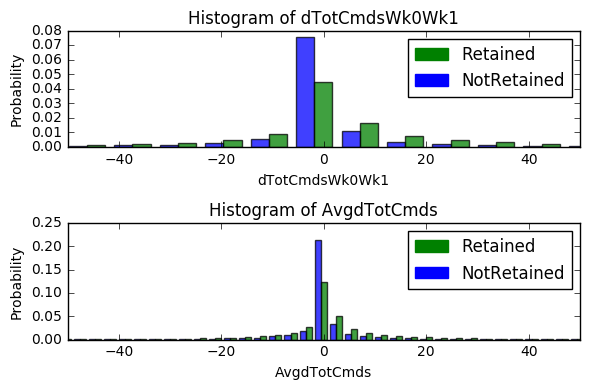

In [14]:
# make some plots of the variables of interest
# the histogram of the data


plt.figure(1)
plt.subplot(211)
plt.hist([derivDFNo.dTotCmdsWk0Wk1, derivDFYes.dTotCmdsWk0Wk1], 50, normed=2, alpha=0.75)
plt.axis([-50, 50, 0, 0.08])
grn_patch = mpatches.Patch(color='green', label='Retained')
blue_patch = mpatches.Patch(color='blue', label='NotRetained')
plt.legend(handles=[grn_patch, blue_patch])
plt.xlabel('dTotCmdsWk0Wk1')
plt.ylabel('Probability')
plt.title('Histogram of dTotCmdsWk0Wk1')
#plt.text(60, .025, r'$\mu=100,\ \sigma=15$')

plt.subplot(212)
plt.hist([derivDFNo.AvgdTotCmds, derivDFYes.AvgdTotCmds], 50, normed=1, alpha=0.75)
plt.axis([-50, 50, 0, 0.25])
plt.xlabel('AvgdTotCmds')
plt.ylabel('Probability')
plt.title('Histogram of AvgdTotCmds')
#plt.grid(True)
grn_patch = mpatches.Patch(color='green', label='Retained')
blue_patch = mpatches.Patch(color='blue', label='NotRetained')
plt.legend(handles=[grn_patch, blue_patch])
plt.tight_layout()
plt.show()

# plots show that not retained are more negative values for Avg and dTotCmds


In [15]:
# random forest prediction
# with train/test split
#

# it takes 9000 sec (2.5 hrs) on full data set (39M devices running Excel) on desktop machine
# and yields nearly the same results, so using 500k sample for all future runs

np.random.seed(732)
derivDF['is_train'] = np.random.uniform(0, 1, len(derivDF)) <= .75

train, test = derivDF[derivDF['is_train']==True], derivDF[derivDF['is_train']==False]

# predictors to use
predictorsTemp = predictorsAll

# params n_estimators=10, max_features=5, min_samples_split=5, n_jobs=2
# use more estimators, 4 max features, n_jobs=2 means use two cores in parallel
clfTT = RandomForestClassifier(n_estimators=40, max_features=2, min_samples_split=10, n_jobs=2)
start = time.time()
clfTT.fit(train[predictorsTemp], train["RetainedExcel"])
print("training time: % sec", time.time() - start)

# predict based on model and show results
preds = clfTT.predict(test[predictorsTemp])
print(pd.crosstab(test["RetainedExcel"], preds, rownames=["Actual"], colnames=["Pred"]))

# score it
score = clfTT.score(test[predictorsTemp], test["RetainedExcel"])
print("Accuracy on test dataset: %",score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("AUC: %", roc_auc_score(test.RetainedExcel, clfTT.predict(test[predictorsTemp])))

# with full dataset
#training time: % sec 9032.093394756317
#Pred          0        1
#Actual                  
#0       1525010  1467288
#1       1140707  5759276
#Accuracy on test dataset: % 0.736360602777
#AUC: % 0.672162416563

# with sample and n_estimators=20, max_features=4, min_smaples_split=5
#training time: % sec 14.555599212646484
#Pred        0      1
#Actual              
#0       19763  18265
#1       15682  71446
#Accuracy on test dataset: % 0.728762504395
#AUC: % 0.669853974963

# with sample and n_estimators=40, max_features=2, min_samples_split=10, n_jobs=2
#training time: % sec 17.28408145904541
#Pred        0      1
#Actual              
#0       19416  18612
#1       14696  72432
#Accuracy on test dataset: % 0.733868132571
#AUC: % 0.670949889028

training time: % sec 15.160232543945312
Pred        0      1
Actual              
0       19416  18612
1       14696  72432
Accuracy on test dataset: % 0.733868132571
Accuracy: 0.73 (+/- 0.00)
AUC: % 0.670949889028


0.755219117285
[ 0.          0.35250233  1.        ] [ 0.          0.86294057  1.        ]


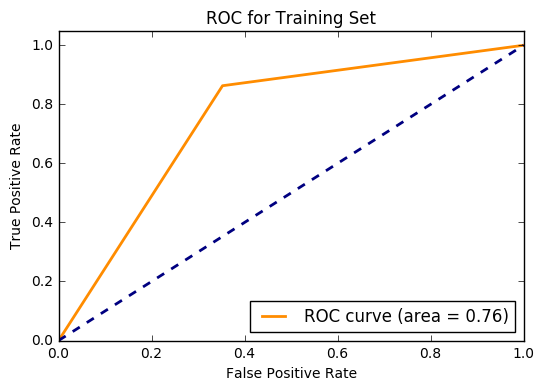

In [16]:
# train fit scoring
fprTrain, tprTrain, _ = roc_curve(train["RetainedExcel"], clfTT.predict(train[predictorsTemp]))

roc_auc_train = auc(fprTrain, tprTrain)

print(roc_auc_train)
print(fprTrain, tprTrain)

# ROC plot
plt.figure()
lw = 2
plt.plot(fprTrain, tprTrain, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Training Set')
plt.legend(loc="lower right")
plt.show()

0.670949889028
[ 0.          0.48942884  1.        ] [ 0.          0.83132862  1.        ]


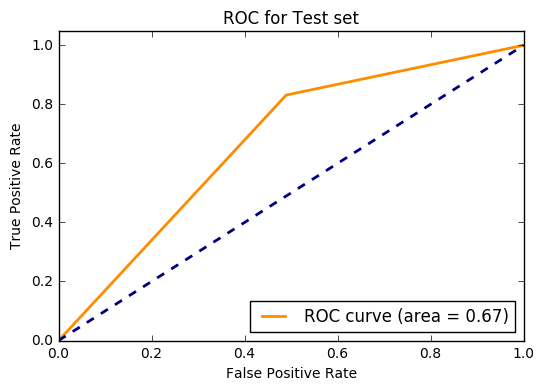

In [17]:
# plot ROC for test set
fpr, tpr, _ = roc_curve(test["RetainedExcel"], preds)

roc_auc = auc(fpr, tpr)

print(roc_auc)
print(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Test set')
plt.legend(loc="lower right")
plt.show()


In [18]:
# test the model on another dataset
# this one is users of Excel on July 31st for the prev 4 weeks
# and retention period is to check the 28 days after a gap of 28 days (M2 Retention)

pathName="E:/python-stuff/data/"
# 500000 sample
#fileName = "DerivativeRetention500000.csv"

# full data set (39M devices, 5 GB csv)
fileName = "DerivativeRetention500000_2016-07-31.csv"
filePath = os.path.join(pathName, fileName)

# load the DF
derivDFJuly = pd.read_csv(filePath)


In [19]:
#print(derivDFJuly.head())

In [20]:
# test model accuracy on the July Excel M2 Retention data

# predictors to use
predictorsJuly = predictorsAll

# predict based on model and show results
preds = clfTT.predict(derivDFJuly[predictorsJuly])
print(pd.crosstab(derivDFJuly["RetainedExcel"], preds, rownames=["Actual"], colnames=["Pred"]))

# score it
score = clfTT.score(derivDFJuly[predictorsJuly], derivDFJuly["RetainedExcel"])
print("Accuracy on test dataset: %",score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("AUC: %", roc_auc_score(derivDFJuly.RetainedExcel, clfTT.predict(derivDFJuly[predictorsJuly])))

print("Average Retention for July 31 Excel users: %", derivDFJuly.RetainedExcel.mean()*100)

#Pred        0       1
#Actual               
#0       77175   74281
#1       57185  291359
#Accuracy on test dataset: % 0.737068
#AUC: % 0.672742845849
#Average Retention for July 31 Excel users: % 69.70880000000001


Pred        0       1
Actual               
0       76754   74702
1       57463  291081
Accuracy on test dataset: % 0.73567
Accuracy: 0.74 (+/- 0.00)
AUC: % 0.670954201381
Average Retention for July 31 Excel users: % 69.70880000000001


In [21]:
# what if we run it on Word using the same model
# Aug cohort, M2 Retention

# full data set (39M devices, 5 GB csv)
fileName = "DerivativeRetentionWord500000_2016-08-28.csv"
filePath = os.path.join(pathName, fileName)

# load the DF
derivDFWord = pd.read_csv(filePath)

# predictors to use
predictors = predictorsAll

# predict based on model and show results
preds = clfTT.predict(derivDFWord[predictors])
print(pd.crosstab(derivDFWord["RetainedWord"], preds, rownames=["Actual"], colnames=["Pred"]))

# score it
score = clfTT.score(derivDFWord[predictors], derivDFWord["RetainedWord"])
print("Accuracy on test dataset: %",score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("AUC: %", roc_auc_score(derivDFWord.RetainedWord, clfTT.predict(derivDFWord[predictors])))

print("Average Retention for Aug Word users: %", derivDFWord.RetainedWord.mean()*100)

# first time without outliers removed from excel
#Pred        0       1
#Actual               
#0       72234   78013
#1       64381  285372
#Accuracy on test dataset: % 0.715212
#AUC: % 0.648346357864
#Average Retention for Aug Word users: % 69.9506


Pred        0       1
Actual               
0       71217   79030
1       63795  285958
Accuracy on test dataset: % 0.71435
Accuracy: 0.71 (+/- 0.00)
AUC: % 0.645799664946
Average Retention for Aug Word users: % 69.9506


In [22]:
derivDFWord.describe()

,dDistCmdsWk0Wk1,dDistCmdsWk1Wk2,dDistCmdsWk2Wk3,dTotCmdsWk0Wk1,dTotCmdsWk1Wk2,dTotCmdsWk2Wk3,AvgdDistCmds,AvgdTotCmds,RetainedWord
count,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000,500000.000000
mean,0.613835,0.264161,0.150402,6.879038,2.821548,1.788947,0.342771,3.829833,0.699506
std,8.237764,7.741755,7.425534,483.097744,542.193752,598.355812,2.815747,191.254245,0.458473
min,-176.000000,-234.500000,-144.000000,-74152.500000,-117992.500000,-170584.000000,-50.330000,-56818.250000,0.000000
25%,-1.830000,-1.500000,-1.200000,-5.000000,-4.000000,-3.830000,-0.500000,-1.330000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,3.000000,2.000000,1.580000,12.250000,6.000000,4.500000,1.170000,5.500000,1.000000
max,169.000000,194.000000,287.000000,59352.250000,74123.000000,117992.500000,56.330000,19784.420000,1.000000


In [23]:
# remove outliers?
# try removing all those that have values more than 3 SD away from mean
# remove SqmUserId and SnapshotTime as they are strings
derivDFWordCleaned = derivDFWord.drop(["SqmUserId","SnapshotTime"], axis=1)
derivDFWordCleaned = derivDFWordCleaned[derivDFWordCleaned.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]


In [24]:
# what does it look like now?
derivDFWordCleaned.describe()
#print(derivDFWord.describe())
# lost around 30k devices

,dDistCmdsWk0Wk1,dDistCmdsWk1Wk2,dDistCmdsWk2Wk3,dTotCmdsWk0Wk1,dTotCmdsWk1Wk2,dTotCmdsWk2Wk3,AvgdDistCmds,AvgdTotCmds,RetainedWord
count,470229.000000,470229.000000,470229.000000,470229.000000,470229.000000,470229.000000,470229.000000,470229.000000,470229.000000
mean,0.615112,0.224158,0.099929,5.983253,1.955936,0.959664,0.313037,2.966272,0.699151
std,5.995828,5.464045,5.242047,126.151105,121.691943,121.646326,2.080556,46.223260,0.458628
min,-24.000000,-22.860000,-22.100000,-1442.200000,-1617.750000,-1783.750000,-8.100000,-569.250000,0.000000
25%,-1.500000,-1.330000,-1.000000,-4.000000,-4.000000,-3.000000,-0.470000,-1.330000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,3.000000,2.000000,1.500000,11.000000,5.500000,4.000000,1.100000,4.890000,1.000000
max,25.250000,23.330000,22.400000,1454.250000,1629.000000,1795.170000,8.780000,575.710000,1.000000


In [25]:
# after removing word outliers, does the model perform any better?

# predict based on model and show results
preds = clfTT.predict(derivDFWordCleaned[predictors])
print(pd.crosstab(derivDFWordCleaned["RetainedWord"], preds, rownames=["Actual"], colnames=["Pred"]))

# score it
score = clfTT.score(derivDFWordCleaned[predictors], derivDFWordCleaned["RetainedWord"])
print("Accuracy on test dataset: %",score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))


print("AUC: %", roc_auc_score(derivDFWordCleaned.RetainedWord, clfTT.predict(derivDFWordCleaned[predictors])))

print("Average Retention for Aug Word users: %", derivDFWordCleaned.RetainedWord.mean()*100)

# output
#Pred        0       1
#Actual               
#0       68986   72482
#1       64341  264420
#Accuracy on test dataset: % 0.709029005017
#AUC: % 0.645968164367
#Average Retention for Aug Word users: % 69.91508392719292

# not really better so try training on Word data next


Pred        0       1
Actual               
0       67693   73775
1       59917  268844
Accuracy on test dataset: % 0.715687462917
Accuracy: 0.72 (+/- 0.00)
AUC: % 0.64812651827
Average Retention for Aug Word users: % 69.91508392719292


In [26]:
# try retraining for Word data
# 500,000 sample, Aug 28, 2016 M2 Retention

np.random.seed(732)
derivDFWordCleaned['is_train'] = np.random.uniform(0, 1, len(derivDFWordCleaned)) <= .75

train, test = derivDFWordCleaned[derivDFWordCleaned['is_train']==True], derivDFWordCleaned[derivDFWordCleaned['is_train']==False]

# predictors to use
predictorsTemp = predictorsAll

# params n_estimators=10, max_features=5, min_samples_split=5, n_jobs=2
# use more estimators, 4 max features, n_jobs=2 means use two cores in parallel
clfTTWord = RandomForestClassifier(n_estimators=40, max_features=2, min_samples_split=10, n_jobs=2)
start = time.time()
clfTTWord.fit(train[predictorsTemp], train["RetainedWord"])
print("training time: % sec", time.time() - start)

# predict based on model and show results
preds = clfTTWord.predict(test[predictorsTemp])
print(pd.crosstab(test["RetainedWord"], preds, rownames=["Actual"], colnames=["Pred"]))

# score it
score = clfTTWord.score(test[predictorsTemp], test["RetainedWord"])
print("Accuracy on test dataset: %",score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("AUC: %", roc_auc_score(test.RetainedWord, clfTTWord.predict(test[predictorsTemp])))

print("Average Retention for Aug Word users: %", derivDFWordCleaned.RetainedWord.mean()*100)
# prior to removing outliers
#training time: % sec 13.549851179122925
#Pred        0      1
#Actual              
#0       15744  21937
#1       13782  73693
#Accuracy on test dataset: % 0.714604173991
#AUC: % 0.630134859718

# after removing outliers and reducing to two features
#training time: % sec 19.38641047477722
#Pred        0      1
#Actual              
#0       14429  20713
#1       12315  70175
#Accuracy on test dataset: % 0.719226060936
#AUC: % 0.630650246053
#Average Retention for Aug Word users: % 69.91508392719292

training time: % sec 12.841031789779663
Pred        0      1
Actual              
0       14330  20812
1       12173  70317
Accuracy on test dataset: % 0.719591607726
Accuracy: 0.72 (+/- 0.00)
AUC: % 0.630102385501
Average Retention for Aug Word users: % 69.91508392719292


In [27]:
# still the same best features - slope in wk0 - wk1 commands and avg
clfTTWord.feature_importances_

array([ 0.11043747,  0.08769649,  0.08388643,  0.17777396,  0.12798312,
        0.12716513,  0.11752335,  0.16753405])

In [28]:
#Lastly, test M1 Retention and/or retrain model and see if accuracy improves or gets worse
#
# Excel August cohort, M1 Retention
# DerivativeRetentionExcelM1500000_2016-08-28.csv

fileName = "DerivativeRetentionExcelM1_500000_2016-08-28.csv"
filePath = os.path.join(pathName, fileName)

# load the DF
derivDFExcelM1 = pd.read_csv(filePath)

# predictors to use
predictors = predictorsAll

# predict based on model and show results
preds = clfTT.predict(derivDFExcelM1[predictors])
print(pd.crosstab(derivDFExcelM1["RetainedExcel"], preds, rownames=["Actual"], colnames=["Pred"]))

# score it
score = clfTT.score(derivDFExcelM1[predictors], derivDFExcelM1["RetainedExcel"])
print("Accuracy on test dataset: %",score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("AUC: %", roc_auc_score(derivDFExcelM1.RetainedExcel, clfTT.predict(derivDFExcelM1[predictors])))

print("Average M1 Retention for Aug Excel users: %", derivDFExcelM1.RetainedExcel.mean()*100)

# Using Excel M2 model
#Pred        0       1
#Actual               
#0       73065   52072
#1       62831  312032
#Accuracy on test dataset: % 0.770194
#Accuracy: 0.77 (+/- 0.00)
#AUC: % 0.708134750193
#Average M1 Retention for Aug Excel users: % 74.9726


Pred        0       1
Actual               
0       73065   52072
1       62831  312032
Accuracy on test dataset: % 0.770194
Accuracy: 0.77 (+/- 0.00)
AUC: % 0.708134750193
Average M1 Retention for Aug Excel users: % 74.9726


In [29]:
# retrain the model to see if performance is better

# clean outliers
derivDFExcelM1Cleaned = derivDFExcelM1.drop(["SqmUserId","SnapshotTime"], axis=1)
derivDFExcelM1Cleaned = derivDFExcelM1Cleaned[derivDFExcelM1Cleaned.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

np.random.seed(732)
derivDFExcelM1Cleaned['is_train'] = np.random.uniform(0, 1, len(derivDFExcelM1Cleaned)) <= .75

train, test = derivDFExcelM1Cleaned[derivDFExcelM1Cleaned['is_train']==True], derivDFExcelM1Cleaned[derivDFExcelM1Cleaned['is_train']==False]

# predictors to use
predictorsTemp = predictorsAll

# params n_estimators=10, max_features=5, min_samples_split=5, n_jobs=2
# use more estimators, 4 max features, n_jobs=2 means use two cores in parallel
clfTTExcelM1 = RandomForestClassifier(n_estimators=40, max_features=2, min_samples_split=10, n_jobs=2)
start = time.time()
clfTTExcelM1.fit(train[predictorsTemp], train["RetainedExcel"])
print("training time: % sec", time.time() - start)

# predict based on model and show results
preds = clfTTExcelM1.predict(test[predictorsTemp])
print(pd.crosstab(test["RetainedExcel"], preds, rownames=["Actual"], colnames=["Pred"]))

# score it
score = clfTTExcelM1.score(test[predictorsTemp], test["RetainedExcel"])
print("Accuracy on test dataset: %",score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("AUC: %", roc_auc_score(test.RetainedExcel, clfTTExcelM1.predict(test[predictorsTemp])))

print("Average M1 Retention for Aug Excel users: %", derivDFExcelM1Cleaned.RetainedExcel.mean()*100)

# results
#Pred        0      1
#Actual              
#0       14041  15187
#1       10636  75886
#Accuracy on test dataset: % 0.77690712743
#Accuracy: 0.78 (+/- 0.00)
#AUC: % 0.678733619288
#Average M1 Retention for Aug Excel users: % 74.72231826432709

# looks like predicting M1 retention is about as good as predicting M2 For Excel 2016


training time: % sec 11.355395793914795
Pred        0      1
Actual              
0       14041  15187
1       10636  75886
Accuracy on test dataset: % 0.77690712743
Accuracy: 0.78 (+/- 0.00)
AUC: % 0.678733619288
Average M1 Retention for Aug Excel users: % 74.72231826432709


0.678733619288
[ 0.          0.51960449  1.        ] [ 0.          0.87707173  1.        ]


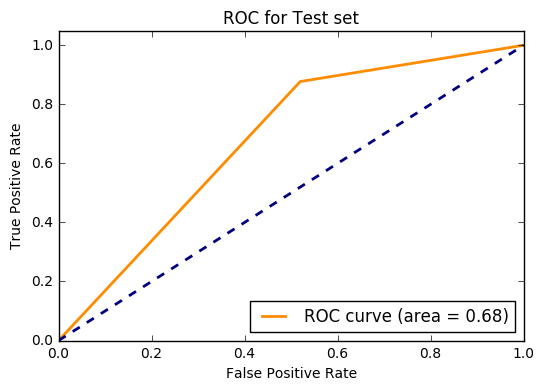

In [30]:
# plot ROC
fpr, tpr, _ = roc_curve(test["RetainedExcel"], preds)

roc_auc = auc(fpr, tpr)

print(roc_auc)
print(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Test set')
plt.legend(loc="lower right")
plt.show()

In [31]:
# use model for Word M1 and/or retrain
#Lastly, test M1 Retention and/or retrain model and see if accuracy improves or gets worse
#
# Word August cohort, M1 Retention

fileName = "DerivativeRetentionWordM1_500000_2016-08-28.csv"
filePath = os.path.join(pathName, fileName)

# load the DF
derivDFWordM1 = pd.read_csv(filePath)

# predict based on model and show results
preds = clfTTExcelM1.predict(derivDFWordM1[predictors])
print(pd.crosstab(derivDFWordM1["RetainedWord"], preds, rownames=["Actual"], colnames=["Pred"]))

# score it
score = clfTTExcelM1.score(derivDFWordM1[predictors], derivDFWordM1["RetainedWord"])
print("Accuracy on test dataset: %",score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("AUC: %", roc_auc_score(derivDFWordM1.RetainedWord, clfTTExcelM1.predict(derivDFWordM1[predictors])))

print("Average M1 Retention for Aug Word users: %", derivDFWordM1.RetainedWord.mean()*100)

Pred        0       1
Actual               
0       53899   70069
1       50651  325381
Accuracy on test dataset: % 0.75856
Accuracy: 0.76 (+/- 0.00)
AUC: % 0.650041456931
Average M1 Retention for Aug Word users: % 75.2064


In [32]:
#OK, try training on Word M1 data then

# clean outliers
derivDFWordM1Cleaned = derivDFWordM1.drop(["SqmUserId","SnapshotTime"], axis=1)
derivDFWordM1Cleaned = derivDFWordM1Cleaned[derivDFWordM1Cleaned.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

np.random.seed(732)
derivDFWordM1Cleaned['is_train'] = np.random.uniform(0, 1, len(derivDFWordM1Cleaned)) <= .75

train, test = derivDFWordM1Cleaned[derivDFWordM1Cleaned['is_train']==True], derivDFWordM1Cleaned[derivDFWordM1Cleaned['is_train']==False]

# predictors to use
predictorsTemp = predictorsAll

# params n_estimators=10, max_features=5, min_samples_split=5, n_jobs=2
# use more estimators, 4 max features, n_jobs=2 means use two cores in parallel
clfTTWordM1 = RandomForestClassifier(n_estimators=40, max_features=2, min_samples_split=10, n_jobs=2)
start = time.time()
clfTTWordM1.fit(train[predictorsTemp], train["RetainedWord"])
print("training time: % sec", time.time() - start)

# predict based on model and show results
preds = clfTTWordM1.predict(test[predictorsTemp])
print(pd.crosstab(test["RetainedWord"], preds, rownames=["Actual"], colnames=["Pred"]))

# score it
score = clfTTWordM1.score(test[predictorsTemp], test["RetainedWord"])
print("Accuracy on test dataset: %",score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("AUC: %", roc_auc_score(test.RetainedWord, clfTTWordM1.predict(test[predictorsTemp])))

print("Average M1 Retention for Aug Word users: %", derivDFWordM1Cleaned.RetainedWord.mean()*100)


training time: % sec 12.238199472427368
Pred        0      1
Actual              
0       12564  16688
1       10853  77393
Accuracy on test dataset: % 0.765604520928
Accuracy: 0.77 (+/- 0.00)
AUC: % 0.653261674499
Average M1 Retention for Aug Word users: % 75.05413018068941


In [33]:
#what if we try the Word model on Excel M1?
# predict based on model and show results
preds = clfTTWordM1.predict(derivDFExcelM1[predictors])
print(pd.crosstab(derivDFExcelM1["RetainedExcel"], preds, rownames=["Actual"], colnames=["Pred"]))

# score it
score = clfTTWordM1.score(derivDFExcelM1[predictors], derivDFExcelM1["RetainedExcel"])
print("Accuracy on test dataset: %",score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("AUC: %", roc_auc_score(derivDFExcelM1.RetainedExcel, clfTTWordM1.predict(derivDFExcelM1[predictors])))

print("Average M1 Retention for Aug Excel users: %", derivDFExcelM1.RetainedExcel.mean()*100)

# results
#Pred        0       1
#Actual               
#0       56518   68619
#1       42228  332635
#Accuracy on test dataset: % 0.778306
#Accuracy: 0.78 (+/- 0.00)
#AUC: % 0.669499919106
#Average M1 Retention for Aug Excel users: % 74.9726


Pred        0       1
Actual               
0       56518   68619
1       42228  332635
Accuracy on test dataset: % 0.778306
Accuracy: 0.78 (+/- 0.00)
AUC: % 0.669499919106
Average M1 Retention for Aug Excel users: % 74.9726


Looks like training on Word works well for predicting Excel, but vice versa doesn't perform quite as well
And that Predicting M1 Retention is possible, but works better for Excel than Word.

In [34]:
# OK, try the Word M1 model on Consumers, specifically Excel

#DerivativeRetentionExcelM1_Consumer500000_2016-08-28.csv

fileName = "DerivativeRetentionExcelM1_Consumer500000_2016-08-28.csv"
filePath = os.path.join(pathName, fileName)

# load the DF
derivDFExcelConsumerM1 = pd.read_csv(filePath)

# predict based on model and show results
preds = clfTTWordM1.predict(derivDFExcelConsumerM1[predictors])
print(pd.crosstab(derivDFExcelConsumerM1["RetainedExcel"], preds, rownames=["Actual"], colnames=["Pred"]))

# score it
score = clfTTWordM1.score(derivDFExcelConsumerM1[predictors], derivDFExcelConsumerM1["RetainedExcel"])
print("Accuracy on test dataset: %",score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("AUC: %", roc_auc_score(derivDFExcelConsumerM1.RetainedExcel, clfTTWordM1.predict(derivDFExcelConsumerM1[predictors])))

print("Average M1 Retention for Aug Excel users: %", derivDFExcelConsumerM1.RetainedExcel.mean()*100)


Pred        0       1
Actual               
0       56865   65698
1       46463  330974
Accuracy on test dataset: % 0.775678
Accuracy: 0.78 (+/- 0.00)
AUC: % 0.670432066026
Average M1 Retention for Aug Excel users: % 75.48740000000001


In [35]:
# OK, try the Word M1 model on Consumers, specifically PPT

#DerivativeRetentionPPTM1_Consumer500000_2016-08-28.csv

fileName = "DerivativeRetentionPPTM1_Consumer500000_2016-08-28.csv"
filePath = os.path.join(pathName, fileName)

# load the DF
derivDFPPTConsumerM1 = pd.read_csv(filePath)

# predict based on model and show results
preds = clfTTWordM1.predict(derivDFPPTConsumerM1[predictors])
print(pd.crosstab(derivDFPPTConsumerM1["RetainedPpt"], preds, rownames=["Actual"], colnames=["Pred"]))

# score it
score = clfTTWordM1.score(derivDFPPTConsumerM1[predictors], derivDFPPTConsumerM1["RetainedPpt"])
print("Accuracy on test dataset: %",score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("AUC: %", roc_auc_score(derivDFPPTConsumerM1.RetainedPpt, clfTTWordM1.predict(derivDFPPTConsumerM1[predictors])))

print("Average M1 Retention for Aug PPT users: %", derivDFPPTConsumerM1.RetainedPpt.mean()*100)

Pred         0       1
Actual                
0       109885  112825
1        61869  215421
Accuracy on test dataset: % 0.650612
Accuracy: 0.65 (+/- 0.00)
AUC: % 0.635139644527
Average M1 Retention for Aug PPT users: % 55.458


In [36]:
# OK, try the Word M1 model on Consumers, specifically Word

fileName = "DerivativeRetentionWordM1_Consumer500000_2016-08-28.csv"
filePath = os.path.join(pathName, fileName)

# load the DF
derivDFWordConsumerM1 = pd.read_csv(filePath)

# predict based on model and show results
preds = clfTTWordM1.predict(derivDFWordConsumerM1[predictors])
print(pd.crosstab(derivDFWordConsumerM1["RetainedWord"], preds, rownames=["Actual"], colnames=["Pred"]))

# score it
score = clfTTWordM1.score(derivDFWordConsumerM1[predictors], derivDFWordConsumerM1["RetainedWord"])
print("Accuracy on test dataset: %",score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("AUC: %", roc_auc_score(derivDFWordConsumerM1.RetainedWord, clfTTWordM1.predict(derivDFWordConsumerM1[predictors])))

print("Average M1 Retention for Aug Word users: %", derivDFWordConsumerM1.RetainedWord.mean()*100)

Pred        0       1
Actual               
0       46445   63378
1       52190  337987
Accuracy on test dataset: % 0.768864
Accuracy: 0.77 (+/- 0.00)
AUC: % 0.644573981664
Average M1 Retention for Aug Word users: % 78.0354


In [37]:
# OK, try the Word M1 model on Commercial, specifically Excel

fileName = "DerivativeRetentionExcelM1_Commercial500000_2016-08-28.csv"
filePath = os.path.join(pathName, fileName)

# load the DF
derivDFExcelCommercialM1 = pd.read_csv(filePath)

# predict based on model and show results
preds = clfTTWordM1.predict(derivDFExcelCommercialM1[predictors])
print(pd.crosstab(derivDFExcelCommercialM1["RetainedExcel"], preds, rownames=["Actual"], colnames=["Pred"]))

# score it
score = clfTTWordM1.score(derivDFExcelCommercialM1[predictors], derivDFExcelCommercialM1["RetainedExcel"])
print("Accuracy on test dataset: %",score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("AUC: %", roc_auc_score(derivDFExcelCommercialM1.RetainedExcel, clfTTWordM1.predict(derivDFExcelCommercialM1[predictors])))

print("Average M1 Retention for Aug Excel users: %", derivDFExcelCommercialM1.RetainedExcel.mean()*100)

Pred        0       1
Actual               
0       34741   53875
1       32563  378821
Accuracy on test dataset: % 0.827124
Accuracy: 0.83 (+/- 0.00)
AUC: % 0.656442528285
Average M1 Retention for Aug Excel users: % 82.27680000000001


In [38]:
# OK, try the Word M1 model all users, specifically PPT

fileName = "DerivativeRetentionPPTM1500000_2016-08-28.csv"
filePath = os.path.join(pathName, fileName)

# load the DF
derivDFPPTM1 = pd.read_csv(filePath)

# predict based on model and show results
preds = clfTTWordM1.predict(derivDFPPTM1[predictors])
print(pd.crosstab(derivDFPPTM1["RetainedPpt"], preds, rownames=["Actual"], colnames=["Pred"]))

# score it
score = clfTTWordM1.score(derivDFPPTM1[predictors], derivDFPPTM1["RetainedPpt"])
print("Accuracy on test dataset: %",score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("AUC: %", roc_auc_score(derivDFPPTM1.RetainedPpt, clfTTWordM1.predict(derivDFPPTM1[predictors])))

print("Average M1 Retention for Aug PPT users: %", derivDFPPTM1.RetainedPpt.mean()*100)

Pred        0       1
Actual               
0       95211  109777
1       58474  236538
Accuracy on test dataset: % 0.663498
Accuracy: 0.66 (+/- 0.00)
AUC: % 0.633131102286
Average M1 Retention for Aug PPT users: % 59.0024


In [83]:
# gather all the CSVs for the below runs
# can call powershell directly from python!
# only need to run this once
# should add a check to see if the files exist and then not run this cell

# word commercial
#subprocess.call(["C:\\WINDOWS\\system32\\WindowsPowerShell\\v1.0\\powershell.exe", 
#                 "Export-CosmosStreamToCSV 'https://cosmos14.osdinfra.net/cosmos/ACE.proc/users/tedscott/DerivativeRetentionWordM1_Commercial500000_2016-08-28.ss' 'E:\python-stuff\data\DerivativeRetentionWordM1_Commercial500000_2016-08-28.csv'"])

# ppt commercial
#subprocess.call(["C:\\WINDOWS\\system32\\WindowsPowerShell\\v1.0\\powershell.exe", 
#                 "Export-CosmosStreamToCSV 'https://cosmos14.osdinfra.net/cosmos/ACE.proc/users/tedscott/DerivativeRetentionPPTM1_Commercial500000_2016-08-28.ss' 'E:\python-stuff\data\DerivativeRetentionPPTM1_Commercial500000_2016-08-28.csv'"])

# Excel EDU
#subprocess.call(["C:\\WINDOWS\\system32\\WindowsPowerShell\\v1.0\\powershell.exe", 
#                 "Export-CosmosStreamToCSV 'https://cosmos14.osdinfra.net/cosmos/ACE.proc/users/tedscott/DerivativeRetentionExcelM1_Edu500000_2016-08-28.ss' 'E:\python-stuff\data\DerivativeRetentionExcelM1_Edu500000_2016-08-28.csv'"])

# Word EDU
#subprocess.call(["C:\\WINDOWS\\system32\\WindowsPowerShell\\v1.0\\powershell.exe", 
#                 "Export-CosmosStreamToCSV 'https://cosmos14.osdinfra.net/cosmos/ACE.proc/users/tedscott/DerivativeRetentionWordM1_Edu500000_2016-08-28.ss' 'E:\python-stuff\data\DerivativeRetentionWordM1_Edu500000_2016-08-28.csv'"])

# PPT EDU
#subprocess.call(["C:\\WINDOWS\\system32\\WindowsPowerShell\\v1.0\\powershell.exe", 
#                 "Export-CosmosStreamToCSV 'https://cosmos14.osdinfra.net/cosmos/ACE.proc/users/tedscott/DerivativeRetentionPPTM1_Edu500000_2016-08-28.ss' 'E:\python-stuff\data\DerivativeRetentionPPTM1_Edu500000_2016-08-28.csv'"])


0

In [51]:
# Word M1 Commercial
fileName =  "DerivativeRetentionWordM1_Commercial500000_2016-08-28.csv"
filePath = os.path.join(pathName, fileName)

# load the DF
derivDFWordM1Commercial = pd.read_csv(filePath)

# predict based on model and show results
preds = clfTTWordM1.predict(derivDFWordM1Commercial[predictors])
print(pd.crosstab(derivDFWordM1Commercial["RetainedWord"], preds, rownames=["Actual"], colnames=["Pred"]))

# score it
score = clfTTWordM1.score(derivDFWordM1Commercial[predictors], derivDFWordM1Commercial["RetainedWord"])
print("Accuracy on test dataset: %",score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("AUC: %", roc_auc_score(derivDFWordM1Commercial.RetainedWord, clfTTWordM1.predict(derivDFWordM1Commercial[predictors])))

print("Average M1 Retention for Aug Word Commercial users: %", derivDFWordM1Commercial.RetainedWord.mean()*100)


Pred        0       1
Actual               
0       27376   47754
1       37837  387033
Accuracy on test dataset: % 0.828818
Accuracy: 0.83 (+/- 0.00)
AUC: % 0.637663131264
Average M1 Retention for Aug Word Commercial users: % 84.974


In [52]:
# PPT M1 Commercial
fileName =  "DerivativeRetentionPPTM1_Commercial500000_2016-08-28.csv"
filePath = os.path.join(pathName, fileName)

# load the DF
derivDFPPTM1Commercial = pd.read_csv(filePath)

# predict based on model and show results
preds = clfTTWordM1.predict(derivDFPPTM1Commercial[predictors])
print(pd.crosstab(derivDFPPTM1Commercial["RetainedPpt"], preds, rownames=["Actual"], colnames=["Pred"]))

# score it
score = clfTTWordM1.score(derivDFPPTM1Commercial[predictors], derivDFPPTM1Commercial["RetainedPpt"])
print("Accuracy on test dataset: %",score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("AUC: %", roc_auc_score(derivDFPPTM1Commercial.RetainedPpt, clfTTWordM1.predict(derivDFPPTM1Commercial[predictors])))

print("Average M1 Retention for Aug PPT Commercial users: %", derivDFPPTM1Commercial.RetainedPpt.mean()*100)

Pred        0       1
Actual               
0       69541   88993
1       58080  283386
Accuracy on test dataset: % 0.705854
Accuracy: 0.71 (+/- 0.00)
AUC: % 0.634280121699
Average M1 Retention for Aug PPT Commercial users: % 68.2932


In [49]:
# Excel M1 EDU
fileName = "DerivativeRetentionExcelM1_Edu500000_2016-08-28.csv"
filePath = os.path.join(pathName, fileName)

# load the DF
derivDFExcelM1Edu = pd.read_csv(filePath)

# predict based on model and show results
preds = clfTTWordM1.predict(derivDFExcelM1Edu[predictors])
print(pd.crosstab(derivDFExcelM1Edu["RetainedExcel"], preds, rownames=["Actual"], colnames=["Pred"]))

# score it
score = clfTTWordM1.score(derivDFExcelM1Edu[predictors], derivDFExcelM1Edu["RetainedExcel"])
print("Accuracy on test dataset: %",score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("AUC: %", roc_auc_score(derivDFExcelM1Edu.RetainedExcel, clfTTWordM1.predict(derivDFExcelM1Edu[predictors])))

print("Average M1 Retention for Aug Excel Edu users: %", derivDFExcelM1Edu.RetainedExcel.mean()*100)


Pred        0       1
Actual               
0       62586   80184
1       58225  291205
Accuracy on test dataset: % 0.718795205201
Accuracy: 0.72 (+/- 0.00)
AUC: % 0.635870448025
Average M1 Retention for Aug Excel Edu users: % 70.9934985778139


In [48]:
# Word M1 EDU
fileName = "DerivativeRetentionWordM1_Edu500000_2016-08-28.csv"
filePath = os.path.join(pathName, fileName)

# load the DF
derivDFWordM1Edu = pd.read_csv(filePath)

# predict based on model and show results
preds = clfTTWordM1.predict(derivDFWordM1Edu[predictors])
print(pd.crosstab(derivDFWordM1Edu["RetainedWord"], preds, rownames=["Actual"], colnames=["Pred"]))

# score it
score = clfTTWordM1.score(derivDFWordM1Edu[predictors], derivDFWordM1Edu["RetainedWord"])
print("Accuracy on test dataset: %",score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("AUC: %", roc_auc_score(derivDFWordM1Edu.RetainedWord, clfTTWordM1.predict(derivDFWordM1Edu[predictors])))

print("Average M1 Retention for Aug Word Edu users: %", derivDFWordM1Edu.RetainedWord.mean()*100)

Pred        0       1
Actual               
0       29109   50743
1       51816  368332
Accuracy on test dataset: % 0.794882
Accuracy: 0.79 (+/- 0.00)
AUC: % 0.620604461554
Average M1 Retention for Aug Word Edu users: % 84.0296


In [47]:
# PPT M1 EDU
fileName = "DerivativeRetentionPPTM1_Edu500000_2016-08-28.csv"
filePath = os.path.join(pathName, fileName)

# load the DF
derivDFPPTM1Edu = pd.read_csv(filePath)

# predict based on model and show results
preds = clfTTWordM1.predict(derivDFPPTM1Edu[predictors])
print(pd.crosstab(derivDFPPTM1Edu["RetainedPpt"], preds, rownames=["Actual"], colnames=["Pred"]))

# score it
score = clfTTWordM1.score(derivDFPPTM1Edu[predictors], derivDFPPTM1Edu["RetainedPpt"])
print("Accuracy on test dataset: %",score)
print("Accuracy: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

print("AUC: %", roc_auc_score(derivDFPPTM1Edu.RetainedPpt, clfTTWordM1.predict(derivDFPPTM1Edu[predictors])))

print("Average M1 Retention for Aug PPT Edu users: %", derivDFPPTM1Edu.RetainedPpt.mean()*100)

Pred        0       1
Actual               
0       50043   62556
1       38036  145596
Accuracy on test dataset: % 0.660427166637
Accuracy: 0.66 (+/- 0.00)
AUC: % 0.618651954379
Average M1 Retention for Aug PPT Edu users: % 61.98946092745189


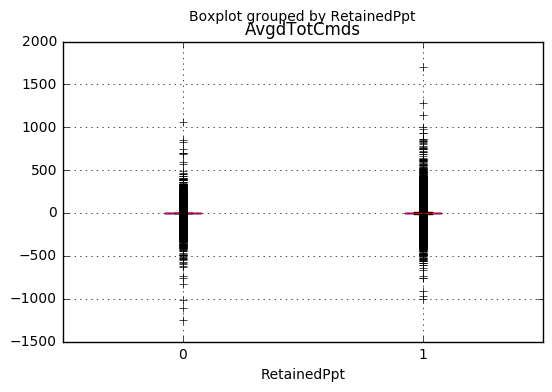

In [45]:
plt.figure()
derivDFPPTM1Edu.boxplot(column='AvgdTotCmds', by='RetainedPpt')
plt.show()

In [91]:

#

subprocess.call(["C:\\WINDOWS\\system32\\WindowsPowerShell\\v1.0\\powershell.exe", 
                 "Export-CosmosStreamToCSV 'https://cosmos14.osdinfra.net/cosmos/ACE.proc/users/tedscott/DerivativeRetentionWordM1500000_2016-08-28.ss' 'E:\python-stuff\data\DerivativeRetentionWordM1_500000_2016-08-28.csv'"])

0